## Many to One (Label is last element in sequence) (One output per sequence) (No Shuffling or batching)

## Import dependencies

In [1]:
import os
import shutil
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
from torchsummary import summary
import matplotlib.pyplot as plt
import torch.nn.functional as F

## Loading the csv files and pre processing to remove header and delimiter

In [2]:
xy_pain = np.loadtxt('C:/Users/Nischal/Desktop/BioVid_split/pain/Pain_features_and_labels_071309_w_21_pain.csv', delimiter=",",dtype=np.float32,skiprows=1)
xy_nopain = np.loadtxt('C:/Users/Nischal/Desktop/BioVid_split/no_pain/Pain_features_and_labels_071309_w_21_no_pain.csv', delimiter=",",dtype=np.float32,skiprows=1)

## Making pain and no pain classes to be of equal sizes
x_p=(xy_pain[:,:-1])
y_p=(xy_pain[:,[-1]])
x_np=(xy_nopain[:len(x_p),:-1])
y_np=(xy_nopain[:len(x_p),[-1]])
# print(len(x_np[0]),len(x_p))

###### Test train split:
train=np.round(len(x_p)*0.7)
test=len(x_p)-train

x_p_train= (x_p[:int(train)])
x_p_test = (x_p[int(train):])

y_p_train= y_p[:int(train)]
y_p_test = y_p[int(train):]

x_np_train= (x_np[:int(train)])
x_np_test = (x_np[int(train):])

y_np_train= y_np[:int(train)]
y_np_test = y_np[int(train):]

x_train= np.vstack((x_p_train,x_np_train))
x_test = np.vstack((x_p_test,x_np_test))

y_train= np.vstack((y_p_train,y_np_train))
y_test = np.vstack((y_p_test,y_np_test))

only_pain_test_x = x_p_test
only_pain_test_y = y_p_test

# print(len(x_test),len(y_train))
# print(x_p_train[0])
# print(x_np_train[0])

In [3]:
## Creating a dataset for Pain related frames

# xy_pain = np.loadtxt('C:/Users/Nischal/Desktop/BioVid_split/pain/Pain_features_and_labels_071309_w_21_pain.csv', delimiter=",",dtype=np.float32,skiprows=1)
# xy_nopain = np.loadtxt('C:/Users/Nischal/Desktop/BioVid_split/no_pain/Pain_features_and_labels_071309_w_21_no_pain.csv', delimiter=",",dtype=np.float32,skiprows=1)
# x_p=(xy_pain[:,:-1])
# y_p=(xy_pain[:,[-1]])
# x_np=(xy_nopain[:,:-1])
# y_np=(xy_nopain[:,[-1]])




def lstm_data_transform(x_data, y_data, num_steps=30):
    """ Changes data to the format for LSTM training 
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    x=torch.from_numpy(x_array)
    y=torch.from_numpy(y_array)
    return x, y

## Sequence processing test and train data

train_x,train_y=lstm_data_transform(x_train,y_train)
test_x,test_y=lstm_data_transform(x_test,y_test)

## Only test for pain

OP_test_x,OP_test_y=lstm_data_transform(only_pain_test_x,only_pain_test_y)

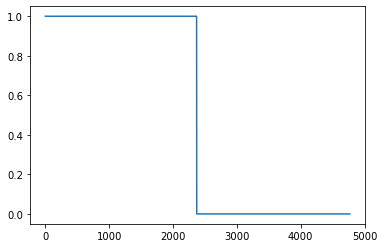

In [4]:
plt.plot(test_y)

In [5]:
## Main part of code, Building architecture and training for the Pain labels

# Device configuration for CPU or GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device = torch.device('cuda')

# Hyper-parameters 
# input_size = 18 AU (Both presence(1) and intensities(17) )
num_classes = 2 ## (Binary classification as pain(0) or no pain(1) )
num_epochs = 1
batch_size = 1
learning_rate = 0.0001

input_size = 18
sequence_length = 30
hidden_size = 50
num_layers = 5


## PAIN DATASET



# Fully connected neural network with one hidden layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Can add sigmoid here itself ################################################## 
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.ones(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.ones(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # Check list sizes here to match required lengths
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN
        out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
#         F.log_softmax(self.linear(bow_vec), dim=1)
        out = self.fc(out)
        out= F.log_softmax((out),dim=1)
        # out: (n, 2)
        return out

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer setting
# criterion = nn.CrossEntropyLoss() ## Useful for later stage where we might have to use pain levels
criterion = nn.NLLLoss()
# criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
m = nn.Sigmoid()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
## Hinge loss try

In [6]:
summary(model,input_size=(1,5,18))
print(model)

Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              95,600
├─Linear: 1-2                            102
Total params: 95,702
Trainable params: 95,702
Non-trainable params: 0
RNN(
  (lstm): LSTM(18, 50, num_layers=5, batch_first=True)
  (fc): Linear(in_features=50, out_features=2, bias=True)
)


In [7]:
## Pain label training for the LSTM model

# Train the model
n_total_steps = len(train_x)
i=0

loss_count=[]
for epoch in range(num_epochs):
    loss_value=0.0
    for features, labels in zip(train_x,train_y): 
        
        features = features.reshape(-1, sequence_length, input_size).to(device)
#         print(features.shape)
        labels = labels.to(device)
        # Forward pass
        outputs = model(features)
#         print(len(labels),len(m(outputs)[0]))
#         print("sh",features.shape)
#         print('out',outputs.shape)
#         print('lab',labels.shape)
        loss = criterion(outputs, labels.long())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i+=1
        loss_value+=loss.item()
        if (i+1) % 1000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.6f}')
    loss_count.append(loss_value/len(train_x))
       

Epoch [1/1], Step [1000/11172], Loss: 0.001160
Epoch [1/1], Step [2000/11172], Loss: 0.000426
Epoch [1/1], Step [3000/11172], Loss: 0.000204
Epoch [1/1], Step [4000/11172], Loss: 0.000109
Epoch [1/1], Step [5000/11172], Loss: 0.000062
Epoch [1/1], Step [6000/11172], Loss: 0.019085
Epoch [1/1], Step [7000/11172], Loss: 0.002093
Epoch [1/1], Step [8000/11172], Loss: 0.000873
Epoch [1/1], Step [9000/11172], Loss: 0.000473
Epoch [1/1], Step [10000/11172], Loss: 0.000284
Epoch [1/1], Step [11000/11172], Loss: 0.000180


In [8]:
loss_count

[0.03144125911435141]

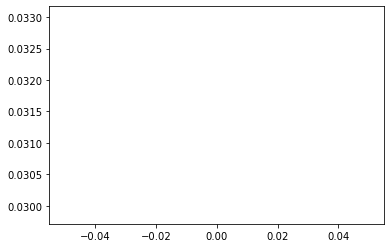

In [9]:
plt.plot(loss_count)

In [10]:
# SAVING THE MODEL

# PATH =r'C:\Users\Nischal\Desktop\LSTM model\saved_model\pain_model.pth'
# torch.save(model.state_dict(), PATH)





In [11]:
# model.load_state_dict(torch.load(PATH, map_location=torch.device('cuda')))

In [12]:
## Testing the model for both labels

model.eval()

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for features, labels in zip(test_x,test_y):
        features = features.reshape(-1, sequence_length, input_size).to(device)
        labels=labels.to(device)
        
        outputs = model(features)
#         print(outputs)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels.long()).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on test data: {acc} %')

Accuracy of the network on test data: 50.314465408805034 %


In [14]:
## Testing the model for pain labels

# model.eval()

# # Test the model
# # In test phase, we don't need to compute gradients (for memory efficiency)
# with torch.no_grad():
#     n_correct = 0
#     n_samples = 0
#     for features, labels in zip(OP_test_x,OP_test_y):
        
#         features = features.reshape(-1, sequence_length, input_size).to(device)
        
#         outputs = model(features)
# #         print(outputs)
#         labels=labels.to(device)
#         _, predicted = torch.max(outputs.data, 1)
# #         print(predicted)
#         n_samples += labels.size(0)
#         n_correct += (predicted == labels.long()).sum().item()

#     acc = 100.0 * n_correct / n_samples
#     print(f'Accuracy of the network on test data: {acc} %')

In [13]:
len(output_list)

NameError: name 'output_list' is not defined